In [1]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt


In [175]:
# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.001, 0, 0.1]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.5, 0.5), (0.001, 1)]  # Reasonable bounds
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(data_grouped['delta_dur_adjusted'], data_grouped['num_of_chose_test'], data_grouped['total_responses']),
        bounds=bounds
    )
    return result.x

In [87]:
# Load data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)
data[:2]

,Unnamed: 0,standard_dur,delta_dur,delta_dur_adjusted,test_dur,rise_dur,test_order,intensity,pre_dur,post_dur,isi_dur,trial_num,total_dur,response,is_correct,response_rt
0,0,1.50,-0.001,-0.001304,1.498696,0.05,1.0,2.5,0.242334,0.240848,0.280321,1.0,3.762154,1.0,0.0,4.264452
1,1,1.75,0.001,0.001522,1.751522,0.05,2.0,2.5,0.267639,0.142134,0.222028,2.0,4.133288,2.0,1.0,0.133298


In [105]:
# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur_adjusted and rise_dur
grouped = data.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('response', 'count'),
).reset_index()

# Step 3: Calculate the proportion of "choose test" responses
grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']
grouped[:2]


,delta_dur_adjusted,rise_dur,num_of_chose_test,total_responses,p_choose_test
0,-0.760870,0.245,0,2,0.0
1,-0.684783,0.245,0,1,0.0


In [166]:
# Fit psychometric function for raw data
def fit_raw_psychometric(X):
    initial_guess = [0.01, -.2, 0.05] # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 0.2)]  # Reasonable bounds
    
    intensities = X['delta_dur_adjusted'].values
    chose_test = X['chose_test'].values
    total_resp = np.ones_like(chose_test)  # Each trial is a single observation
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(intensities, chose_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat


In [152]:
grouped=data.groupby(['delta_dur_adjusted','rise_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('response', 'count'),
).reset_index()

grouped

,delta_dur_adjusted,rise_dur,num_of_chose_test,total_responses
0,-0.760870,0.245,0,2
1,-0.684783,0.245,0,1
2,-0.586957,0.050,0,1
3,-0.586957,0.245,0,1
4,-0.543478,0.050,1,2
...,...,...,...,...
132,0.849130,0.050,1,2
133,0.914348,0.050,1,2
134,0.914565,0.245,1,1
135,1.028696,0.050,1,1


In [154]:
grouped = data.groupby(['delta_dur_adjusted', 'rise_dur', 'standard_dur']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('response', 'count'),
).reset_index()

grouped

,delta_dur_adjusted,rise_dur,standard_dur,num_of_chose_test,total_responses
0,-0.760870,0.245,1.75,0,2
1,-0.684783,0.245,1.75,0,1
2,-0.586957,0.050,1.50,0,1
3,-0.586957,0.245,1.50,0,1
4,-0.543478,0.050,1.25,1,2
...,...,...,...,...,...
133,0.849130,0.050,1.50,1,2
134,0.914348,0.050,1.50,1,2
135,0.914565,0.245,1.75,1,1
136,1.028696,0.050,1.75,1,1


λ: 0.200, μ: 0.031, σ: 1.000
λ: 0.010, μ: 0.451, σ: 0.777


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_34906/1312355860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['p_choose_test'] = X['num_of_chose_test'] / X['total_responses']
/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_34906/1312355860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['p_choose_test'] = X['num_of_chose_test'] / X['total_responses']


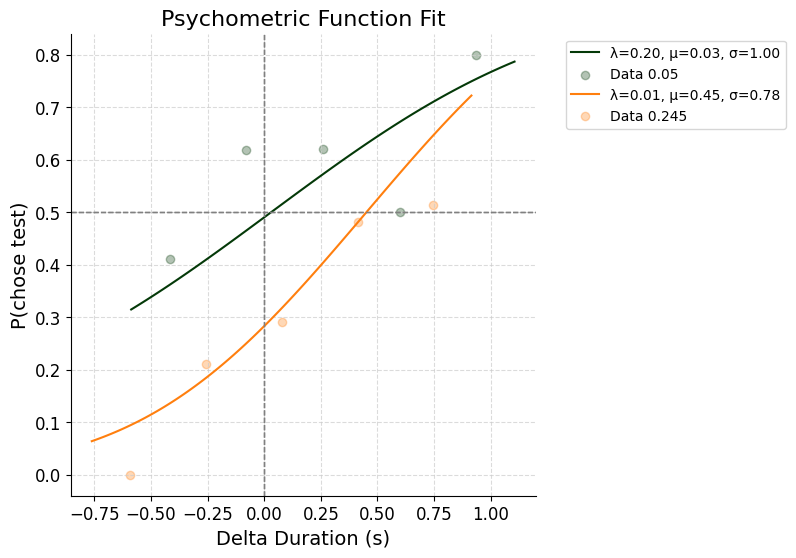

In [172]:

rise_05=grouped[grouped['rise_dur']==0.050]
rise_0245=grouped[grouped['rise_dur']==0.245]

for X in [rise_05,rise_0245]:

    X['p_choose_test'] = X['num_of_chose_test'] / X['total_responses']
    
    lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X)
    print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")
    
    x_data = X['delta_dur_adjusted']
    y_data = X['p_choose_test']
    bin_edges = np.histogram_bin_edges(x_data, bins=5)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    y_data_binned = np.zeros(len(bin_centers))

    for i in range(len(bin_centers)):
        bin_mask = (x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])
        y_data_binned[i] = y_data[bin_mask].mean()

    y_data_smooth_binned = pd.Series(y_data_binned)


    x_fit = np.linspace(min(X['delta_dur_adjusted']), max(X['delta_dur_adjusted']), 100)
    y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
    plt.plot(x_fit, y_fit, label=f'λ={lambda_hat:.2f}, μ={mu_hat:.2f}, σ={sigma_hat:.2f}')
    plt.scatter(bin_centers, y_data_smooth_binned, alpha=0.3, label=f"Data {X['rise_dur'].iloc[0]}")
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Delta Duration (s)')
    plt.ylabel('P(chose test)')
    plt.title('Psychometric Function Fit')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # remove axspines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plt.show()

# PLot is the Overall psychometric function fit withoout grouping by rise_dur or standard_dur


In [149]:
grouped[:2]

,delta_dur_adjusted,rise_dur,num_of_chose_test,total_responses,p_choose_test
0,-0.760870,0.245,0,2,0.0
1,-0.684783,0.245,0,1,0.0


λ: 0.200, μ: 0.500, σ: 1.000
λ: 0.073, μ: 0.404, σ: 1.000
λ: 0.010, μ: 0.274, σ: 0.762
λ: 0.200, μ: -0.365, σ: 1.000
λ: 0.010, μ: -0.357, σ: 0.972
λ: 0.010, μ: 0.500, σ: 0.528
λ: 0.010, μ: 0.209, σ: 0.413
λ: 0.200, μ: 0.292, σ: 1.000


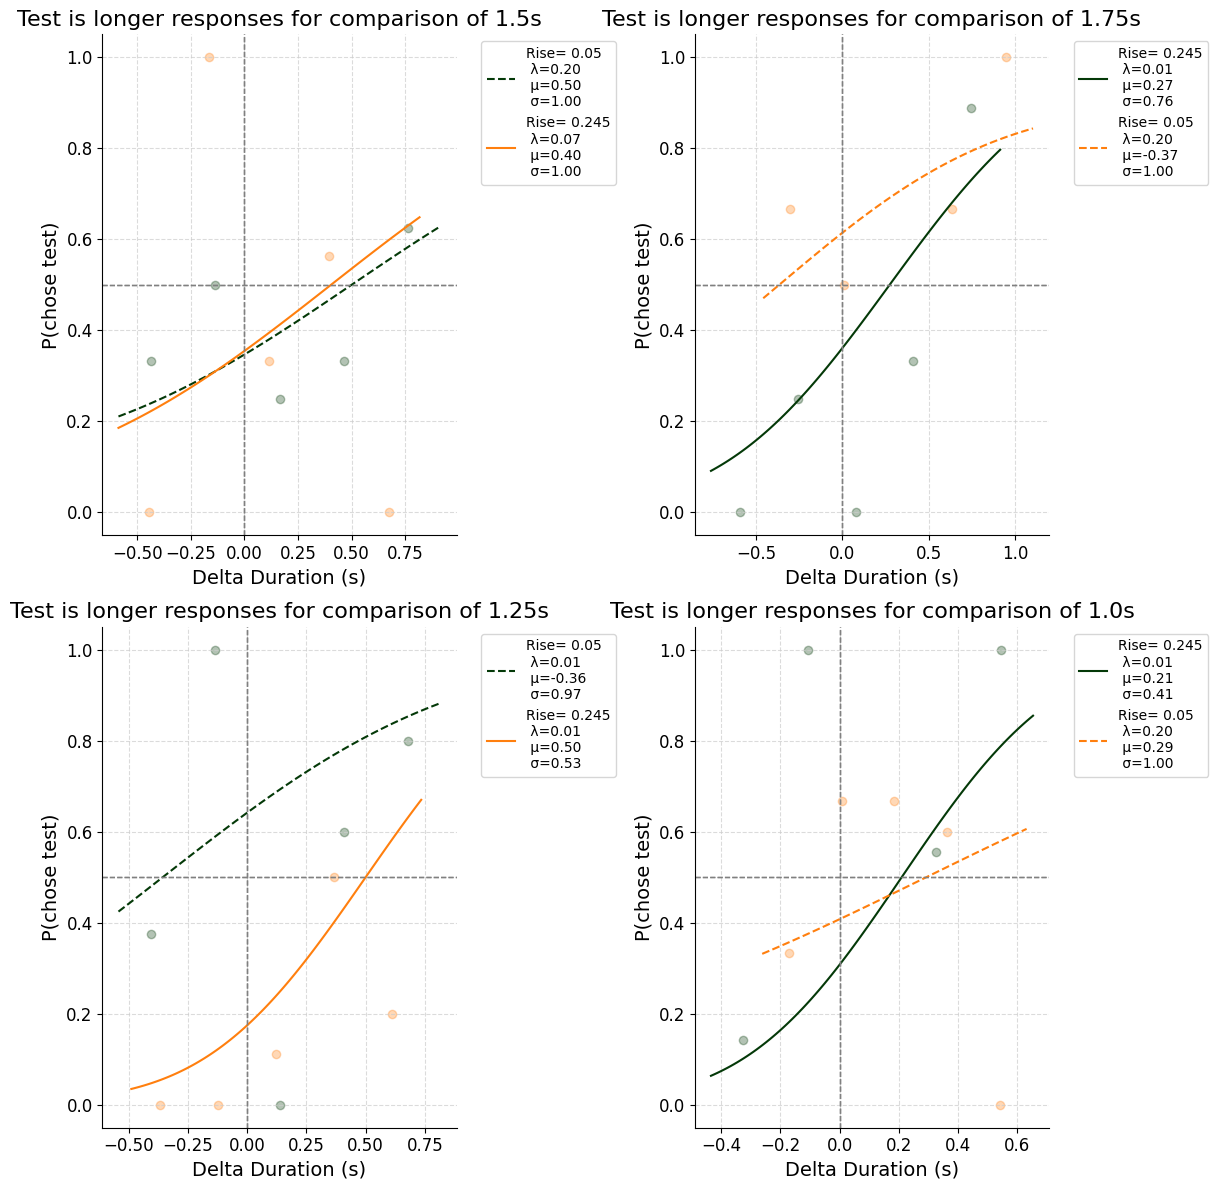

In [176]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for k, i in enumerate(data['standard_dur'].unique()):
    data_by_standard = data[data['standard_dur'] == i].copy()
    data_by_standard.loc[:, 'chose_test'] = (data_by_standard['response'] == data_by_standard['test_order']).astype(int)

    aggregated_data = data_by_standard.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
            num_of_chose_test=('chose_test', 'sum'),
            total_responses=('response', 'count'),
    ).reset_index()
    aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
    for j in aggregated_data['rise_dur'].unique():
        if j == 0.050:
            lineStyle = '--'
        else:
            lineStyle = '-'

        Y = aggregated_data[aggregated_data['rise_dur'] == j]
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(Y)
        print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

        x_data = Y['delta_dur_adjusted']
        y_data = Y['p_choose_test']
        bin_edges = np.histogram_bin_edges(x_data, bins=5)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        y_data_binned = np.zeros(len(bin_centers))
        for m in range(len(bin_centers)):
            bin_mask = (x_data >= bin_edges[m]) & (x_data < bin_edges[m + 1])
            y_data_binned[m] = y_data[bin_mask].mean()

        y_data_smooth_binned = pd.Series(y_data_binned)
        x_fit = np.linspace(min(Y['delta_dur_adjusted']), max(Y['delta_dur_adjusted']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        ax = axs[k // 2, k % 2]
        ax.plot(x_fit, y_fit, linestyle=lineStyle, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
        ax.scatter(bin_centers, y_data_smooth_binned, alpha=0.3)
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Delta Duration (s)')
        ax.set_ylabel('P(chose test)')
        ax.set_title(f'Test is longer responses for comparison of {i}s')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # remove axspines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

    

## Bootstrapping

In [68]:
data[:3]

,Unnamed: 0,standard_dur,delta_dur,delta_dur_adjusted,test_dur,rise_dur,test_order,intensity,pre_dur,post_dur,isi_dur,trial_num,total_dur,response,is_correct,response_rt,chose_test
0,0,1.50,-0.001,-0.001304,1.498696,0.050,1.0,2.5,0.242334,0.240848,0.280321,1.0,3.762154,1.0,0.0,4.264452,1
1,1,1.75,0.001,0.001522,1.751522,0.050,2.0,2.5,0.267639,0.142134,0.222028,2.0,4.133288,2.0,1.0,0.133298,1
2,2,1.50,0.001,0.001304,1.501304,0.245,1.0,2.5,0.262868,0.317743,0.224200,3.0,3.806077,2.0,0.0,0.425712,0


In [67]:
aggregated_data = data.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('response', 'count'),
).reset_index()
aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
aggregated_data[:5]

,delta_dur_adjusted,rise_dur,num_of_chose_test,total_responses,p_choose_test
0,-0.760870,0.245,0,2,0.0
1,-0.684783,0.245,0,1,0.0
2,-0.586957,0.050,0,1,0.0
3,-0.586957,0.245,0,1,0.0
4,-0.543478,0.050,1,2,0.5


In [123]:
# Bootstrapping
def bootstrap_responses(original_data, n_samples=1000):
    resampled_data = []
    for i in range(original_data['delta_dur_adjusted']):
         # resample from the binary trials (B sucess out of T total)
        successes= original_data['num_of_chose_test']
        total_trials = original_data['total_responses']
        failures = total_trials - successes
        all_trials = np.concatenate([np.ones(successes), np.zeros(failures)])
        resampled_trials = np.random.choice(all_trials, len(all_trials), replace=True)
        resampled_data.append(resampled_trials)
    return resampled_data

         

In [148]:
grouped

,delta_dur_adjusted,rise_dur,num_of_chose_test,total_responses,p_choose_test
0,-0.760870,0.245,0,2,0.0
1,-0.684783,0.245,0,1,0.0
2,-0.586957,0.050,0,1,0.0
3,-0.586957,0.245,0,1,0.0
4,-0.543478,0.050,1,2,0.5
...,...,...,...,...,...
132,0.849130,0.050,1,2,0.5
133,0.914348,0.050,1,2,0.5
134,0.914565,0.245,1,1,1.0
135,1.028696,0.050,1,1,1.0


λ 95% CI: [0.01 0.2 ]
μ 95% CI: [0.17283925 0.42932084]
σ 95% CI: [0.87395237 1.        ]
λ 95% CI: [0.01 0.2 ]
μ 95% CI: [0.17283925 0.42932084]
σ 95% CI: [0.87395237 1.        ]


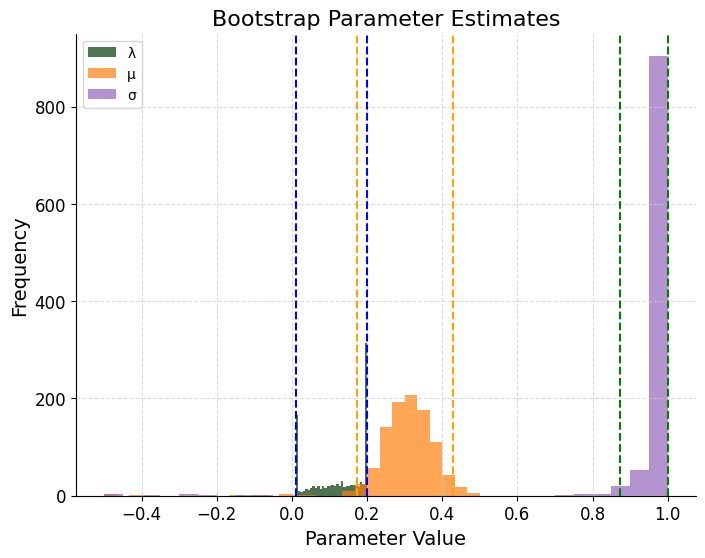

In [173]:
grouped
# Bootstrapping Function
def bootstrap_responses(original_data, n_samples=1000):
    """
    Perform parametric bootstrapping on psychometric data.

    Parameters:
        original_data: DataFrame with columns ['delta_dur_adjusted', 'num_of_chose_test', 'total_responses']
        n_samples: Number of bootstrap iterations.
    
    Returns:
        A list of bootstrapped DataFrames, one for each bootstrap sample.
    """
    bootstrap_results = []
    
    for _ in range(n_samples):
        resampled_data = original_data.copy()
        
        # Resample for each row in the original data
        for idx, row in original_data.iterrows():
            successes = int(row['num_of_chose_test'])
            total_trials = int(row['total_responses'])
            failures = total_trials - successes
            
            # Generate binary trials (1 = success, 0 = failure)
            all_trials = np.concatenate([np.ones(successes), np.zeros(failures)])
            
            # Resample with replacement
            resampled_trials = np.random.choice(all_trials, len(all_trials), replace=True)
            
            # Update the counts for the resampled data
            resampled_data.at[idx, 'num_of_chose_test'] = resampled_trials.sum()
            resampled_data.at[idx, 'total_responses'] = len(resampled_trials)
        
        bootstrap_results.append(resampled_data)
    
    return bootstrap_results

# Fit the psychometric function for each bootstrap sample
bootstrap_fits = []
# Perform bootstrapping
bootstrap_samples = bootstrap_responses(grouped, n_samples=1000)

for sample in bootstrap_samples:
    params = fit_psychometric_function(sample)
    bootstrap_fits.append(params)


# Convert bootstrap results to a DataFrame
bootstrap_fits = pd.DataFrame(bootstrap_fits, columns=['lambda', 'mu', 'sigma'])

# Calculate 95% Confidence Intervals
lambda_ci = np.percentile(bootstrap_fits['lambda'], [2.5, 97.5])
mu_ci = np.percentile(bootstrap_fits['mu'], [2.5, 97.5])
sigma_ci = np.percentile(bootstrap_fits['sigma'], [2.5, 97.5])

print(f"λ 95% CI: {lambda_ci}")
print(f"μ 95% CI: {mu_ci}")
print(f"σ 95% CI: {sigma_ci}")


# Convert bootstrap results to a DataFrame
bootstrap_fits = pd.DataFrame(bootstrap_fits, columns=['lambda', 'mu', 'sigma'])

# Calculate 95% Confidence Intervals
lambda_ci = np.percentile(bootstrap_fits['lambda'], [2.5, 97.5])
mu_ci = np.percentile(bootstrap_fits['mu'], [2.5, 97.5])
sigma_ci = np.percentile(bootstrap_fits['sigma'], [2.5, 97.5])

print(f"λ 95% CI: {lambda_ci}")
print(f"μ 95% CI: {mu_ci}")
print(f"σ 95% CI: {sigma_ci}")

# Plot the bootstrap results
plt.figure(figsize=(8, 6))
plt.hist(bootstrap_fits['lambda'], bins=30, alpha=0.7, label='λ')
plt.hist(bootstrap_fits['mu'], bins=30, alpha=0.7, label='μ')
plt.hist(bootstrap_fits['sigma'], bins=30, alpha=0.7, label='σ')
plt.axvline(lambda_ci[0], color='blue', linestyle='--')
plt.axvline(lambda_ci[1], color='blue', linestyle='--')
plt.axvline(mu_ci[0], color='orange', linestyle='--')
plt.axvline(mu_ci[1], color='orange', linestyle='--')
plt.axvline(sigma_ci[0], color='green', linestyle='--')
plt.axvline(sigma_ci[1], color='green', linestyle='--')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title('Bootstrap Parameter Estimates')
plt.legend()
plt.show()



Figure shows the bootstrap distribution of the psychometric function parameters λ, μ, and σ. The dashed lines represent the 95% confidence intervals for each parameter.
We resampled the data with replacement 1000 times and fit the psychometric function to each resampled dataset. The 95% confidence intervals were calculated from the 2.5th and 97.5th percentiles of the bootstrap distribution.

In [163]:
bootstrap_samples
# flatten the list of DataFrames
bootstrap_samples_flat = pd.concat(bootstrap_samples, ignore_index=True)
bootstrap_samples_flat[:2]


,delta_dur_adjusted,rise_dur,standard_dur,num_of_chose_test,total_responses
0,-0.760870,0.245,1.75,0,2
1,-0.684783,0.245,1.75,0,1


λ: 0.010, μ: 0.280, σ: 0.766
λ: 0.200, μ: -0.376, σ: 1.000
λ: 0.200, μ: 0.500, σ: 1.000
λ: 0.090, μ: 0.404, σ: 1.000
λ: 0.010, μ: -0.351, σ: 0.963
λ: 0.010, μ: 0.500, σ: 0.532
λ: 0.010, μ: 0.210, σ: 0.414
λ: 0.200, μ: 0.291, σ: 1.000


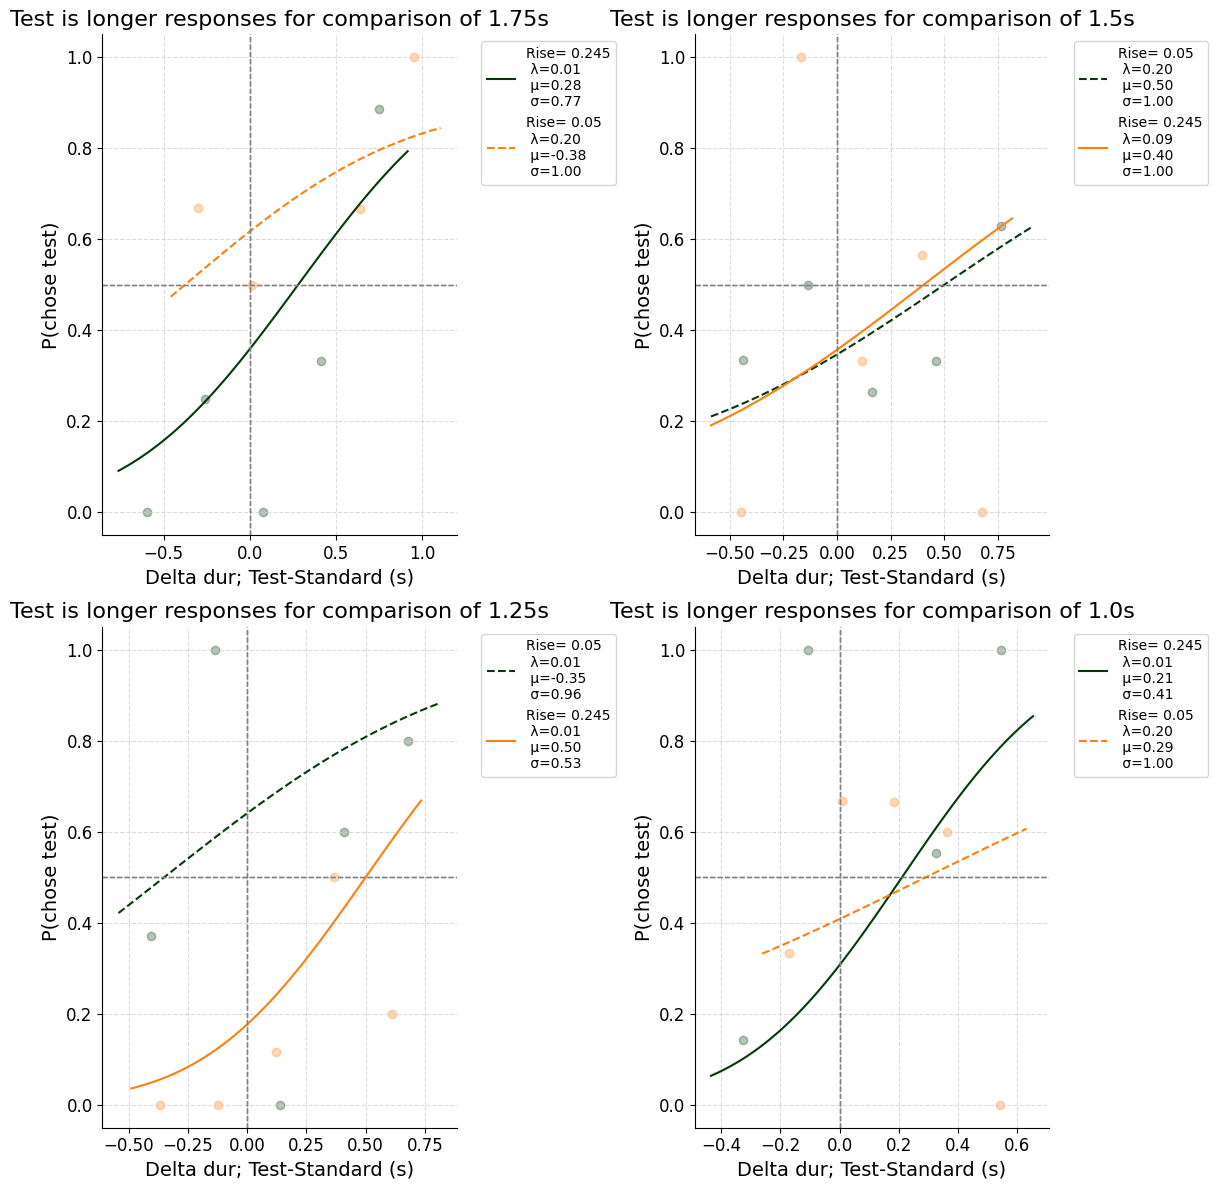

In [195]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
data_boot=bootstrap_samples_flat
plt.title('Bootstraped Psychometric Function Fit')
for k, i in enumerate(data_boot['standard_dur'].unique()):
    data_by_standard = data_boot[data_boot['standard_dur'] == i].copy()

    data_by_standard['p_choose_test'] = data_by_standard['num_of_chose_test'] / data_by_standard['total_responses']
    for j in data_by_standard['rise_dur'].unique():
        if j == 0.050:
            lineStyle = '--'
        else:
            lineStyle = '-'

        Y = data_by_standard[data_by_standard['rise_dur'] == j]
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(Y)
        print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

        x_data = Y['delta_dur_adjusted']
        y_data = Y['p_choose_test']
        bin_edges = np.histogram_bin_edges(x_data, bins=5)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        y_data_binned = np.zeros(len(bin_centers))
        for m in range(len(bin_centers)):
            bin_mask = (x_data >= bin_edges[m]) & (x_data < bin_edges[m + 1])
            y_data_binned[m] = y_data[bin_mask].mean()

        y_data_smooth_binned = pd.Series(y_data_binned)
        x_fit = np.linspace(min(Y['delta_dur_adjusted']), max(Y['delta_dur_adjusted']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        ax = axs[k // 2, k % 2]
        ax.plot(x_fit, y_fit, linestyle=lineStyle, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
        ax.scatter(bin_centers, y_data_smooth_binned, alpha=0.3)
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Delta dur; Test-Standard (s)')
        ax.set_ylabel('P(chose test)')
        ax.set_title(f'Test is longer responses for comparison of {i}s')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # remove axspines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Bootstrapped psychometric function fits.


# Psignifit Fitting

In [204]:
data_boot[:2]

,delta_dur_adjusted,rise_dur,standard_dur,num_of_chose_test,total_responses
0,-0.760870,0.245,1.75,0,2
1,-0.684783,0.245,1.75,0,1


In [201]:
data_boot[["delta_dur_adjusted" ,"num_of_chose_test","total_responses"]][:2]

,delta_dur_adjusted,num_of_chose_test,total_responses
0,-0.760870,0,2
1,-0.684783,0,1


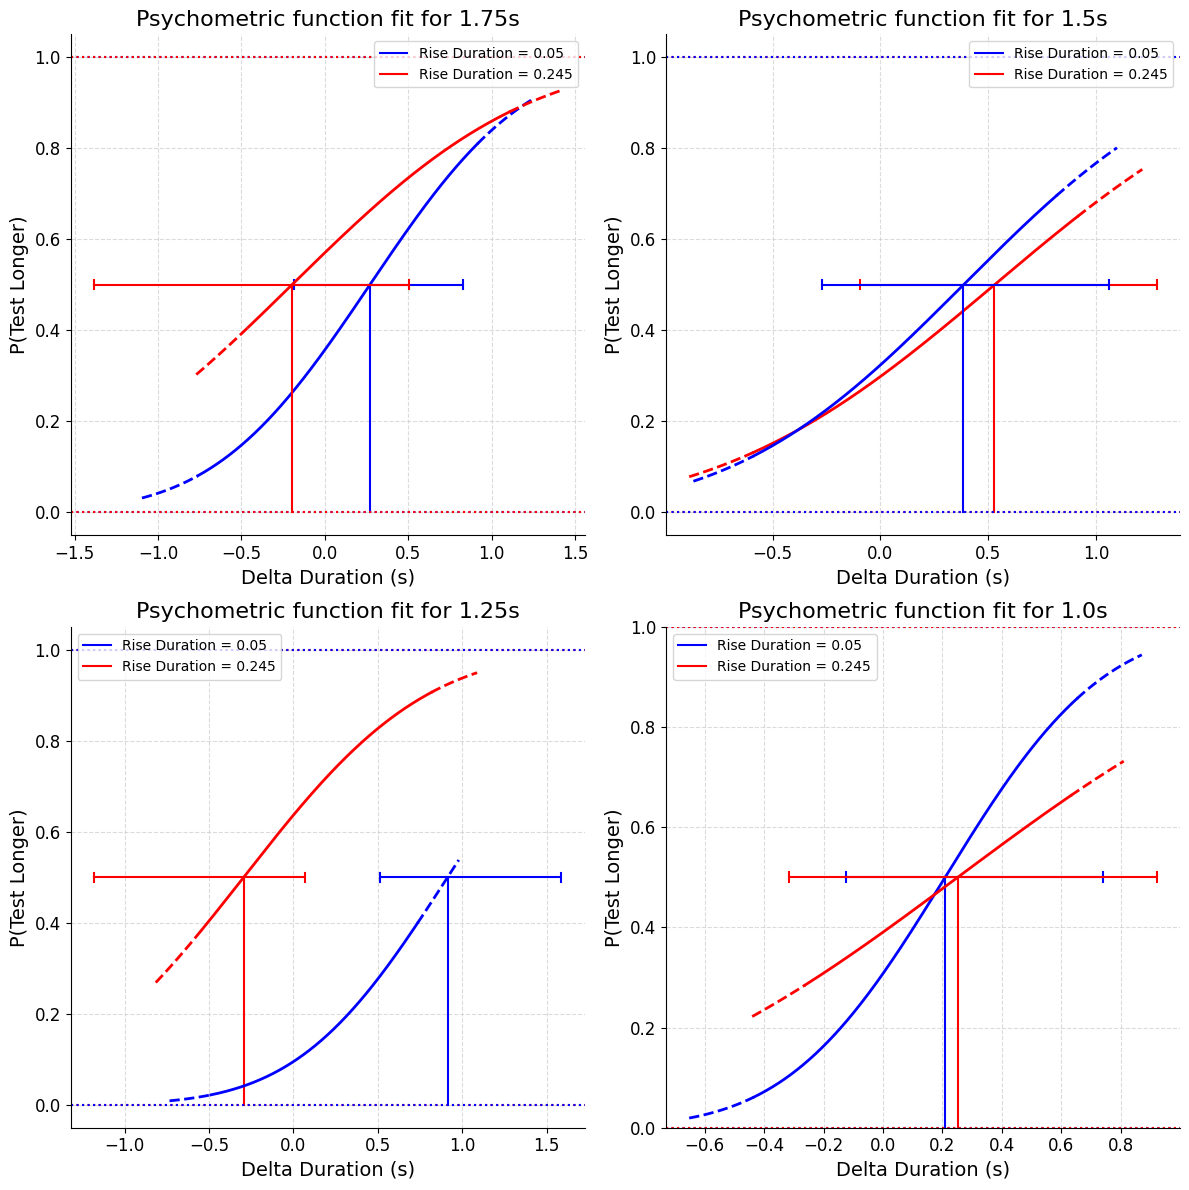

In [ ]:
import psignifit as ps
from psignifit import psigniplot

# grouped[["delta_dur_adjusted" ,"num_of_chose_test","total_responses"]]
# result = ps.psignifit(, experiment_type='yes/no', )
X = grouped
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for k, i in enumerate(X['standard_dur'].unique()):
    data_by_standard = X[X['standard_dur'] == i].copy()
    data_by_standard['p_choose_test'] = data_by_standard['num_of_chose_test'] / data_by_standard['total_responses']
    for j in data_by_standard['rise_dur'].unique():
        if j == 0.050:
            Color = 'red'
        else:
            Color = 'blue'
        Y = data_by_standard[data_by_standard['rise_dur'] == j]
 
        result = ps.psignifit(Y[["delta_dur_adjusted" ,"num_of_chose_test","total_responses"]], experiment_type='equal asymptote',
                               sigmoid='norm',
                               stimulus_range=[-1, 1],)
        ax = axs[k // 2, k % 2]
        psigniplot.plot_psychometric_function(result, plot_data=False, line_color=Color, ax=ax)
        ax.set_title(f'Psychometric function fit for {i}s')
    handles = [plt.Line2D([0], [0], color='blue', label='Rise Duration = 0.05'),
               plt.Line2D([0], [0], color='red', label='Rise Duration = 0.245')]
    ax.legend(handles=handles)
    ax.set_xlabel('Delta Duration (s)')
    ax.set_ylabel('P(Test Longer)')

plt.tight_layout()
plt.show()




<Axes: xlabel='Threshold', ylabel='Marginal Density'>

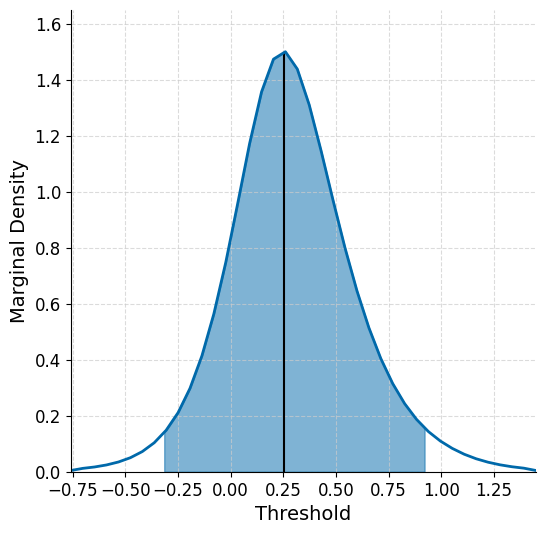

In [223]:
#fig = psigniplot.plot_modelfit(result)
psigniplot.plot_marginal(result, 'threshold')


ValueError: Expects priors and marginals saved. Try running psignifit(....., debug=True).

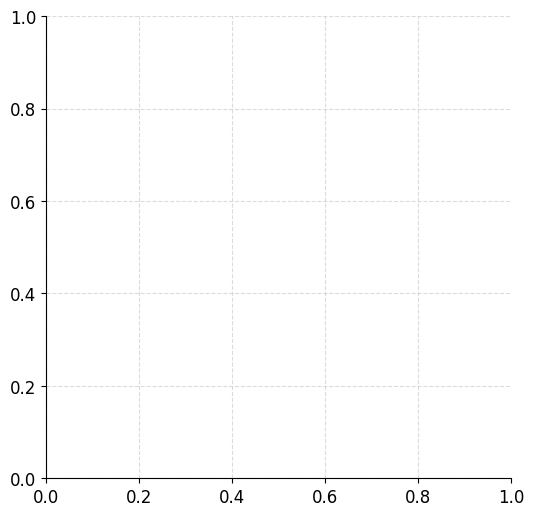

In [225]:
ps.psigniplot.plot_2D_margin(result, 'threshold', 'width')


# Raw data fit

Standard Duration: 1.5, Rise Duration: 0.05, λ: 0.200, μ: 0.300, σ: 1.000
Standard Duration: 1.5, Rise Duration: 0.245, λ: 0.200, μ: -0.300, σ: 0.010


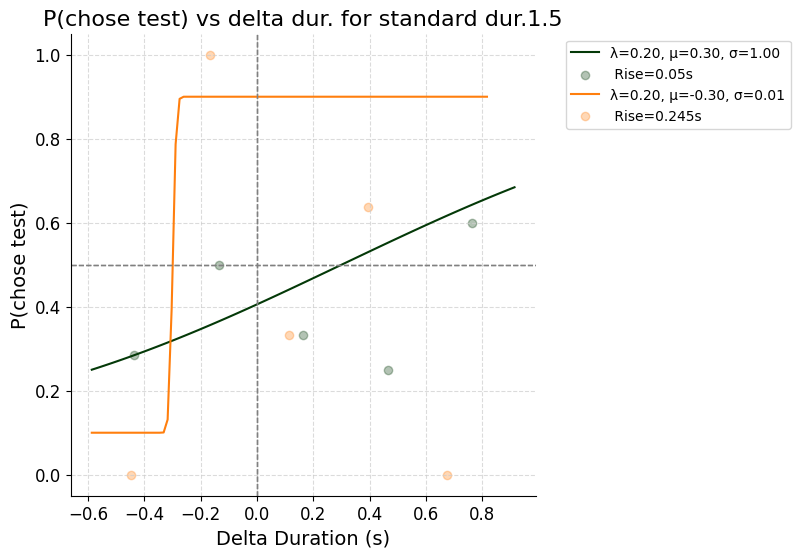

Standard Duration: 1.75, Rise Duration: 0.05, λ: 0.200, μ: -0.300, σ: 1.000
Standard Duration: 1.75, Rise Duration: 0.245, λ: 0.010, μ: 0.274, σ: 0.762


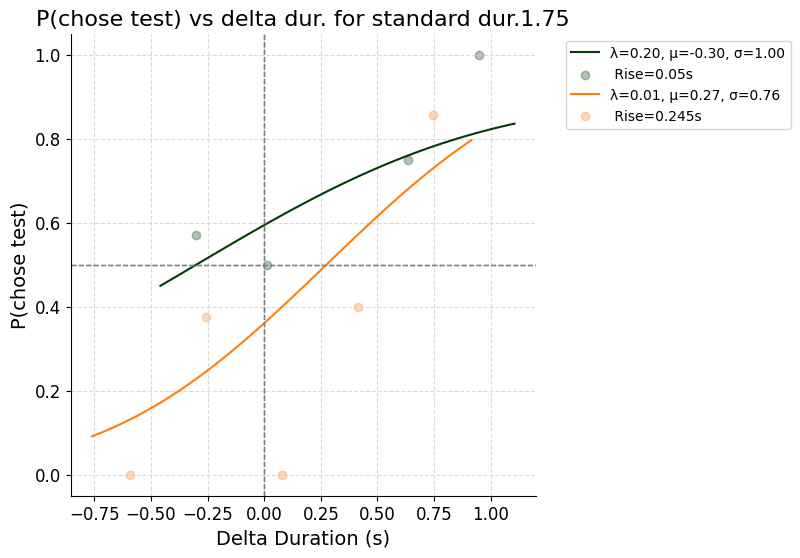

Standard Duration: 1.25, Rise Duration: 0.05, λ: 0.010, μ: -0.300, σ: 0.914
Standard Duration: 1.25, Rise Duration: 0.245, λ: 0.200, μ: 0.300, σ: 0.010


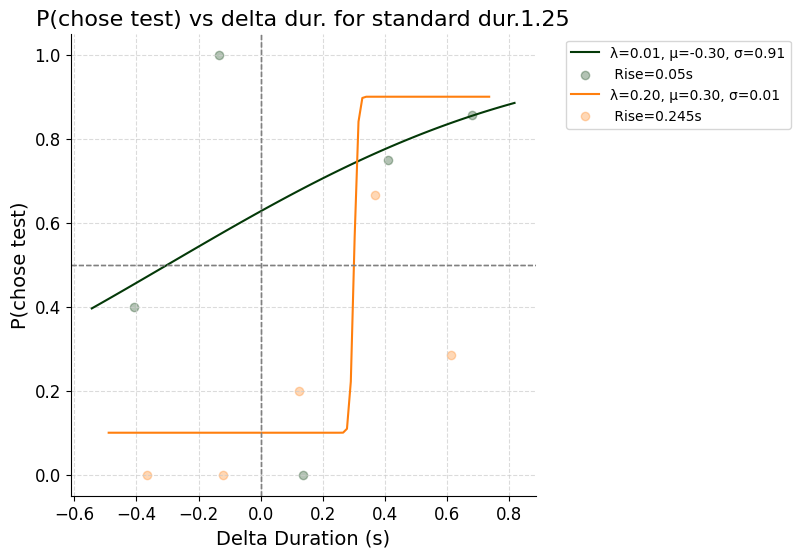

Standard Duration: 1.0, Rise Duration: 0.05, λ: 0.200, μ: 0.267, σ: 0.010
Standard Duration: 1.0, Rise Duration: 0.245, λ: 0.010, μ: 0.209, σ: 0.413


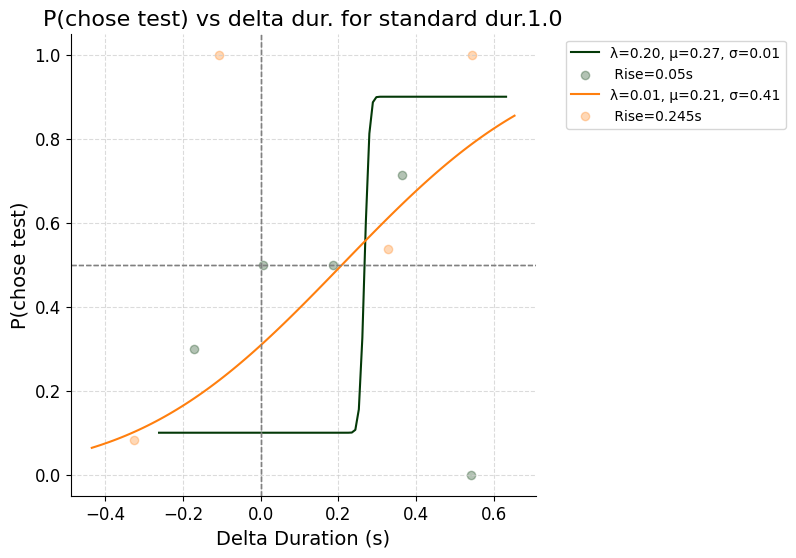

In [179]:
# Fit psychometric function for raw data
def fit_raw_psychometric(X):
    initial_guess = [0.01, -.2, 0.05] # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 1)]  # Reasonable bounds
    
    intensities = X['delta_dur_adjusted'].values
    chose_test = X['chose_test'].values
    total_resp = np.ones_like(chose_test)  # Each trial is a single observation
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(intensities, chose_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat

for standard_duration in data['standard_dur'].unique():
    for rise_duration in data['rise_dur'].unique():
        subset = data[(data['standard_dur'] == standard_duration) & (data['rise_dur'] == rise_duration)]
        lambda_hat, mu_hat, sigma_hat = fit_raw_psychometric(subset)
        print(f"Standard Duration: {standard_duration}, Rise Duration: {rise_duration}, λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")
        
        x_data = subset['delta_dur_adjusted']
        y_data = subset['chose_test']
        bin_edges = np.histogram_bin_edges(x_data, bins=5)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        y_data_binned = np.zeros(len(bin_centers))

        for i in range(len(bin_centers)):
            bin_mask = (x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])
            y_data_binned[i] = y_data[bin_mask].mean()

        y_data_smooth_binned = pd.Series(y_data_binned)

        x_fit = np.linspace(min(subset['delta_dur_adjusted']), max(subset['delta_dur_adjusted']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        plt.plot(x_fit, y_fit, label=f'λ={lambda_hat:.2f}, μ={mu_hat:.2f}, σ={sigma_hat:.2f}')
        plt.scatter(bin_centers, y_data_smooth_binned, alpha=0.3, label=f" Rise={rise_duration}s")
        plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
        plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        plt.xlabel('Delta Duration (s)')
        plt.ylabel('P(chose test)')
        plt.title(f'P(chose test) vs delta dur. for standard dur.{standard_duration}' )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # remove axspines
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.show()
